# Replication of the two-asset model in Auclert, Rognile and Straub  (2020)* with sticky information.

*Auclert, Adrien, Matthew Rognlie, and Ludwig Straub. Micro jumps, macro humps: Monetary policy and business cycles in an estimated HANK model. No. w26647. National Bureau of Economic Research, 2020.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from tabulate import tabulate
import pandas as pd

from HANKnoStickyModel import HANKnoStickyModelClass

# Replication settings

In [2]:
import os
from types import SimpleNamespace

replication_settings = {
    'savefolder': os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models'),   # if empty, the usual "saved" folder is used
    'update_par': {     # updates par for all models
    },
    # specify the replications to be carried out in the notebook
    'do_replicate':{
    },
}

# update parameters for
updated_par=replication_settings['update_par']

In [3]:
def solution_routine(model, do_print=False, print_progress=True, dx=1e-4):
    """ solve model and find IRF"""
    # find steady state
    if print_progress: print(f'Find steady state for {model.name}')
    model.find_ss(do_print=do_print)
    # compute jacs using fake news method
    if print_progress: print(f'Compute jacs for {model.name}')
    model._compute_jac_hh(dx=dx,do_print=do_print,do_direct=False)
    model._compute_jac(inputs='unknowns',dx=dx,do_print=do_print, parallel=True)
    model._compute_jac(inputs='shocks',dx=dx,do_print=do_print, parallel=True)
    # find transition paths
    if print_progress: print(f'Find transition path for {model.name}')
    model.find_transition_path(do_print=do_print, do_print_unknowns=do_print, do_end_check=False)
    # find IRFs
    if print_progress: print(f'Find IRFs for {model.name}')
    model.find_IRFs(do_print=do_print)
    return model

# Solve baseline model

In [4]:
model = HANKnoStickyModelClass(name='baseline', par=updated_par, savefolder=replication_settings['savefolder'])
model = solution_routine(model)

Find steady state for baseline
Compute jacs for baseline
Find transition path for baseline
Find IRFs for baseline


# Sticky information

## Init sticky information model.

In [5]:
updated_par = {**replication_settings['update_par'], **{'inattention': 0.935}}
# init model
model_sticky = HANKnoStickyModelClass(name='sticky_information', par=updated_par)
# solve model
model_sticky.find_ss(do_print=True)
# model_sticky.test_jacs(s_list=[0,20,50])
# model_sticky.find_transition_path(do_print=True, do_print_unknowns=True)
# model_sticky.find_IRFs(do_print=True)

Find optimal beta for market clearing
final evaluation
household problem in ss solved in 1.1 secs [283 iterations]
household problem in ss simulated in 0.2 secs [251 iterations]
steady state found in 28.6 secs
 beta   = 0.95991659
Implied nu =  1.296
Discrepancy in C =  -0.00000000 ->    -0.000000%
Discrepancy in L =   0.00000000 ->     0.000000%
Discrepancy in A =  -0.00000000 ->    -0.000000%
Market clearing residual =  -0.00000000


##  Fake news algorithm vs. direct method
Direct method should not be correct, as the household problem is not formulated accordingly. It should correspond to the solution without sticky information.
Double check if that is the case:

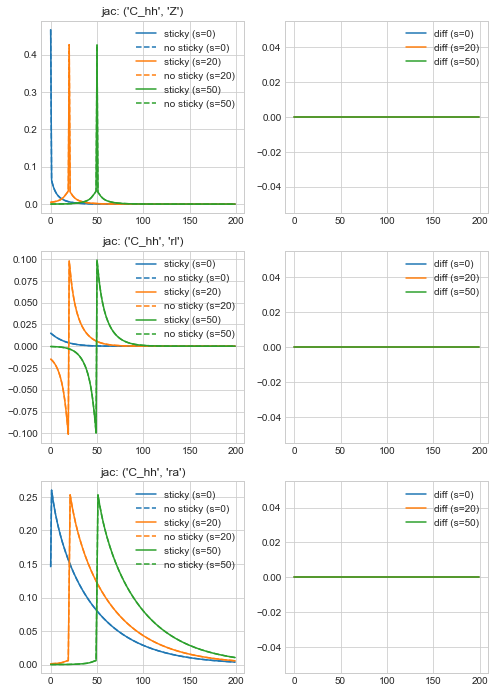

In [6]:
s_list = [0, 20, 50]

# hh_jacs with and without fake news algorithm
model_sticky._compute_jac_hh(dx=1e-4,do_print=False,do_direct=True, s_list=s_list)
jacs_hh_direct_sticky = model_sticky.jac_hh.copy()

model._compute_jac_hh(dx=1e-4,do_print=False,do_direct=True, s_list=s_list)
jacs_hh_direct_no_sticky = model_sticky.jac_hh.copy()

par = model_sticky.par

compare_outputs = ['C_hh']
compare_inputs = ['Z', 'rl', 'ra']

ncols = 2
nrows = len(compare_inputs)*len(compare_outputs)

fig = plt.figure(figsize=(4*ncols, 4*nrows))

fig_i = 0
for output in compare_outputs:
    for input in compare_inputs:
        fig_i += 1
        ax1 = fig.add_subplot(nrows, ncols, fig_i)
        fig_i += 1
        ax2 = fig.add_subplot(nrows, ncols, fig_i)

        jac_name = (output, input)

        for (j, s) in enumerate(s_list):
            diff = model.jac_hh[jac_name][:,s] - model_sticky.jac_hh[jac_name][:,s]
            ax1.plot(np.arange(par.T),model_sticky.jac_hh[jac_name][:,s],color=colors[j],ls='-',label=f'sticky (s={s})')
            ax1.plot(np.arange(par.T),model.jac_hh[jac_name][:,s],color=colors[j],ls='--',label=f'no sticky (s={s})')
            ax1.set_title(f'jac: {jac_name}')
            ax2.plot(np.arange(par.T),diff,color=colors[j],label=f'diff (s={s})')
        ax1.legend()
        ax2.legend()

In [7]:
# use fake news jacs from here on out and compute full jacs
model_sticky.compute_jacs(dx=1e-4,do_print=False,do_direct=False,parallel=True)
# jacs_hh_fake_news = model_sticky.jac_hh.copy()
model._compute_jac_hh(dx=1e-4,do_print=False,do_direct=False)
# jacs_hh_fake_news = model_sticky.jac_hh.copy()

## Check for sluggish response
See if there is a sluggish response of consumption in the sticky information case.
In Auclert et al. This shows the different general equilibrium responses to a expansionary MP shock.
<img src="images\\IRF_Auclert_MP.png" alt="DAG Humps, Jumps" width=400 height=300 />
(They don't state explicitely, what they shock, however before they wrote: "In section 2, we argued that inattention was needed to generate hump-shaped consumption responses to persistent income shocks"

Compare the reaction from household Jacobians to an isolated shock to an input.

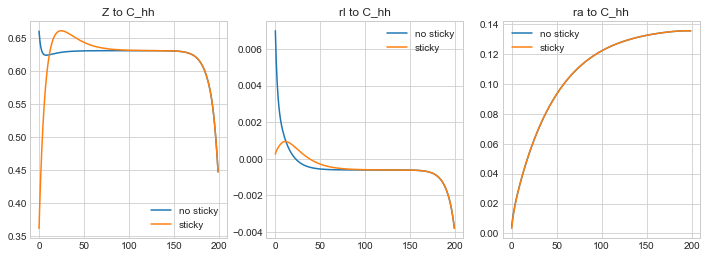

In [8]:
compare_outputs = ['C_hh']
compare_inputs = ['Z', 'rl', 'ra']

shocks_jump = [0.1, -0.01, 0.01]
shocks_rho =[0.6, 0.6, 0.6]

nrows = len(compare_outputs)
ncols = len(compare_inputs)

fig = plt.figure(figsize=(4*ncols, 4*nrows))
fig_i = 0
for output in compare_outputs:
    for i_s, shock in enumerate(compare_inputs):

        shock_series = model.ss.__dict__[shock] + shocks_jump[i_s]*shocks_rho[i_s]**np.arange(par.T)

        IRF_no_sticky = model.jac_hh[(output, shock)] @ shock_series
        IRF_sticky = model_sticky.jac_hh[(output, shock)] @ shock_series

        fig_i += 1
        ax = fig.add_subplot(nrows, ncols, fig_i)
        ax.set_title(f'{shock} to {output}')
        ax.plot(np.arange(par.T), IRF_no_sticky, label='no sticky')
        ax.plot(np.arange(par.T), IRF_sticky, label='sticky')
        ax.legend()

# MP shock response

In [9]:
paths = ['G', 'Y', 'C_hh', 'K', 'I',
         'N', 'w', 'tau', 'Pi', 'Pi_w', 'i', 's', 's_w',
         'L_hh', 'A_hh',
         'rk', 'r','ra', 'rl',
         'q', 'B',
         'p_eq', 'Div', 'p_int', 'Div_int', 'p_k', 'Div_k']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100}

### shocks ###


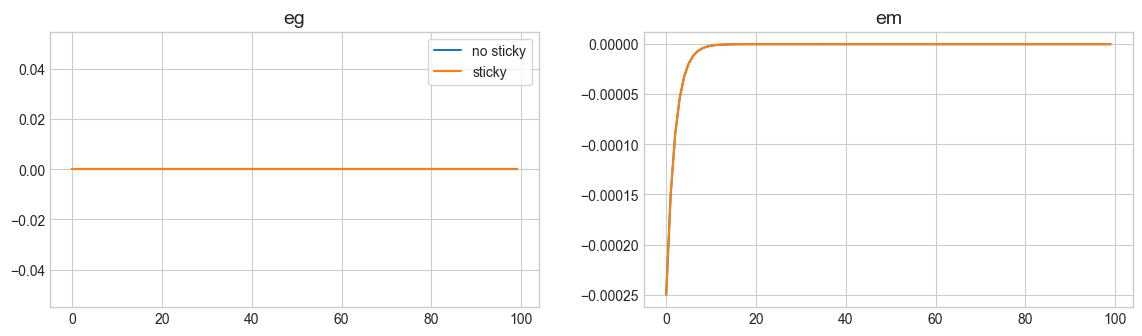


### varnames ###


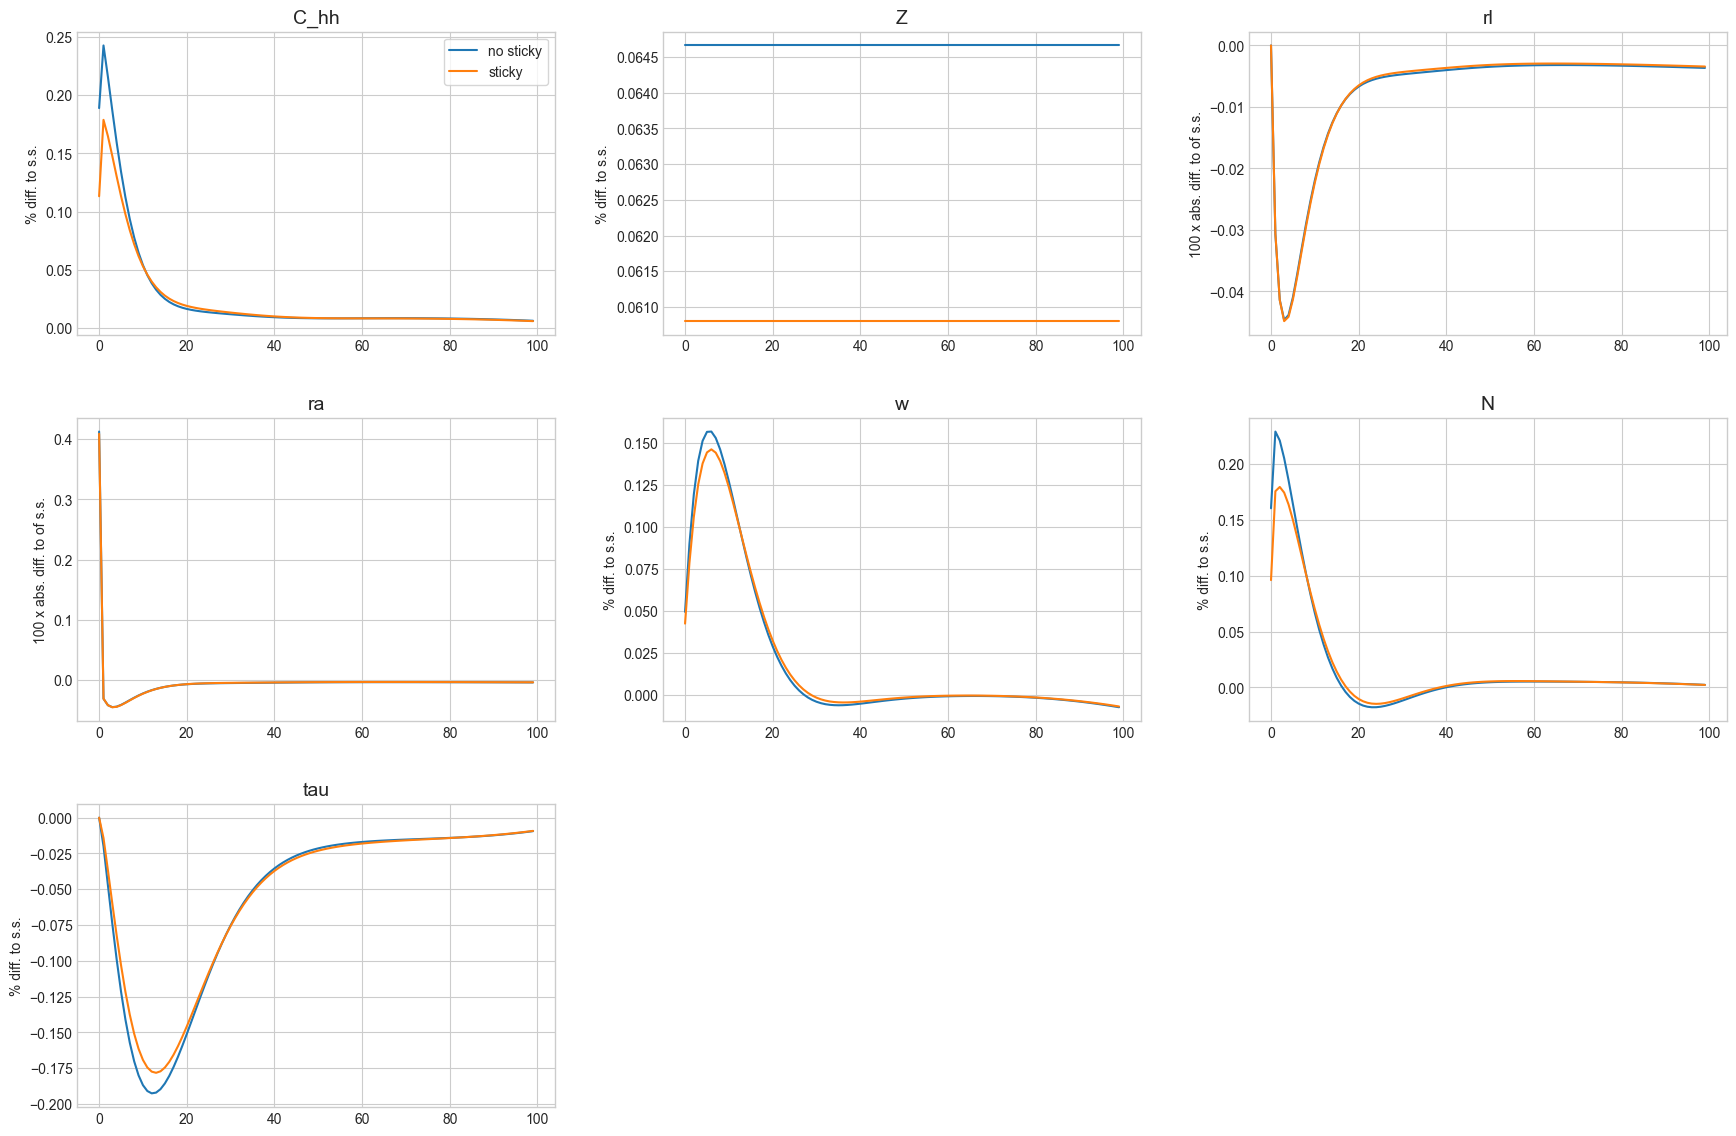


### tagets ###


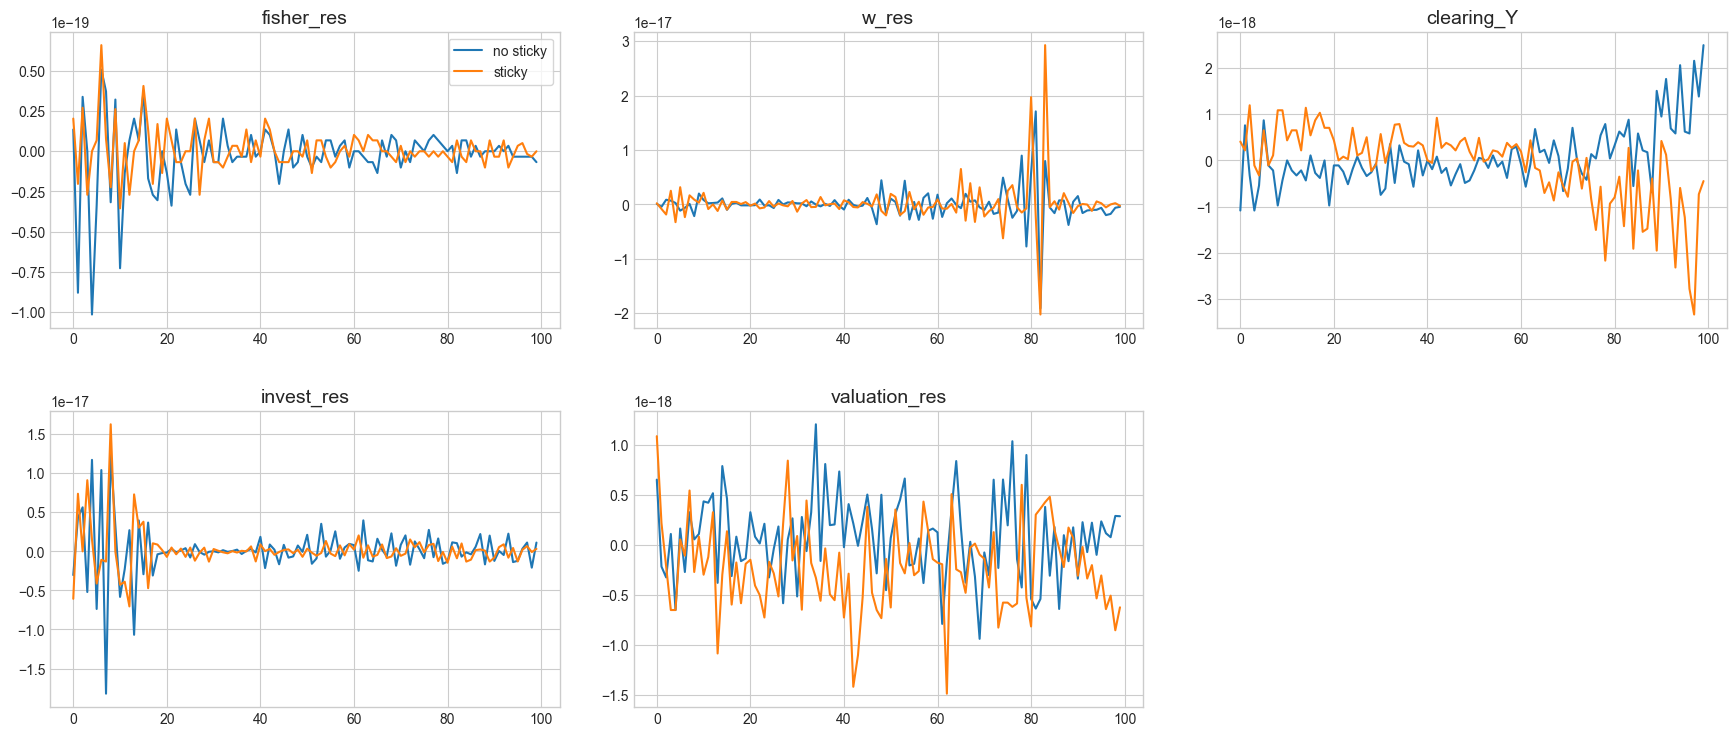

In [10]:
shock_settings = {
                'jump_em': -0.00025,
                'rho_em': 0.6,
                'jump_eg': 0.
            }

model.par.jump_em = shock_settings['jump_em']
model.par.rho_em = shock_settings['rho_em']
model.par.jump_eg = shock_settings['jump_eg']
model.find_IRFs()

model_sticky.par.jump_em = shock_settings['jump_em']
model_sticky.par.rho_em = shock_settings['rho_em']
model_sticky.par.jump_eg = shock_settings['jump_eg']
model_sticky.find_IRFs()

paths_inputs = ['C_hh', 'Z', 'rl', 'ra', 'w', 'N', 'tau']
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths_inputs, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100,
                   do_linear=True, do_non_linear=False)


## Investigate further

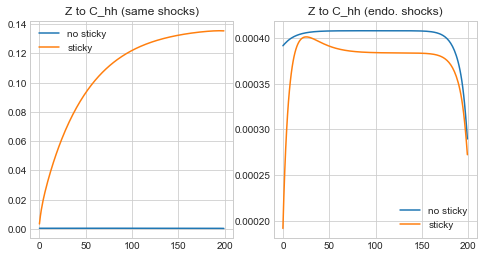

In [11]:
jac_name = ('C_hh', 'Z')

shock_series_no_sticky = model.IRF['Z']
shock_series_sticky = model_sticky.IRF['Z']

IRF_no_sticky = model.jac_hh[jac_name] @ shock_series_no_sticky
IRF_sticky_shock_no_sticky = model_sticky.jac_hh[jac_name] @ shock_series_no_sticky
IRF_sticky_shock_sticky = model_sticky.jac_hh[jac_name] @ shock_series_sticky

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.set_title(f'Z to C_hh (same shocks)')
ax.plot(np.arange(par.T), IRF_no_sticky, label='no sticky')
ax.plot(np.arange(par.T), IRF_sticky, label='sticky')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.set_title(f'Z to C_hh (endo. shocks)')
ax.plot(np.arange(par.T), IRF_no_sticky, label='no sticky')
ax.plot(np.arange(par.T), IRF_sticky_shock_sticky, label='sticky')
ax.legend()

### shocks ###


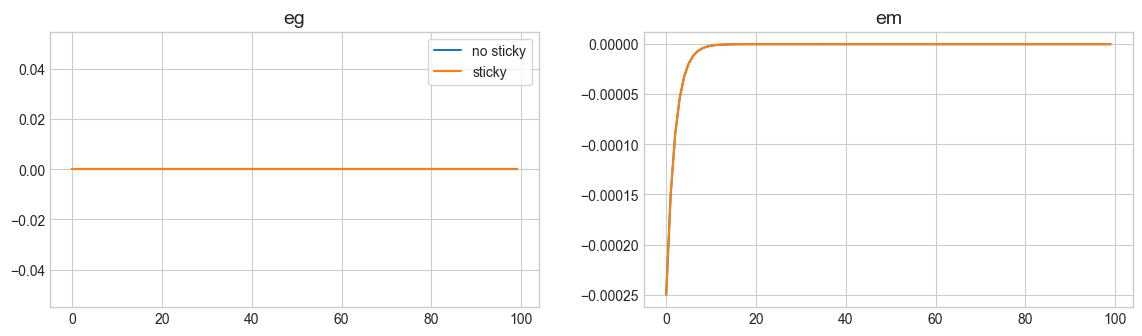


### varnames ###


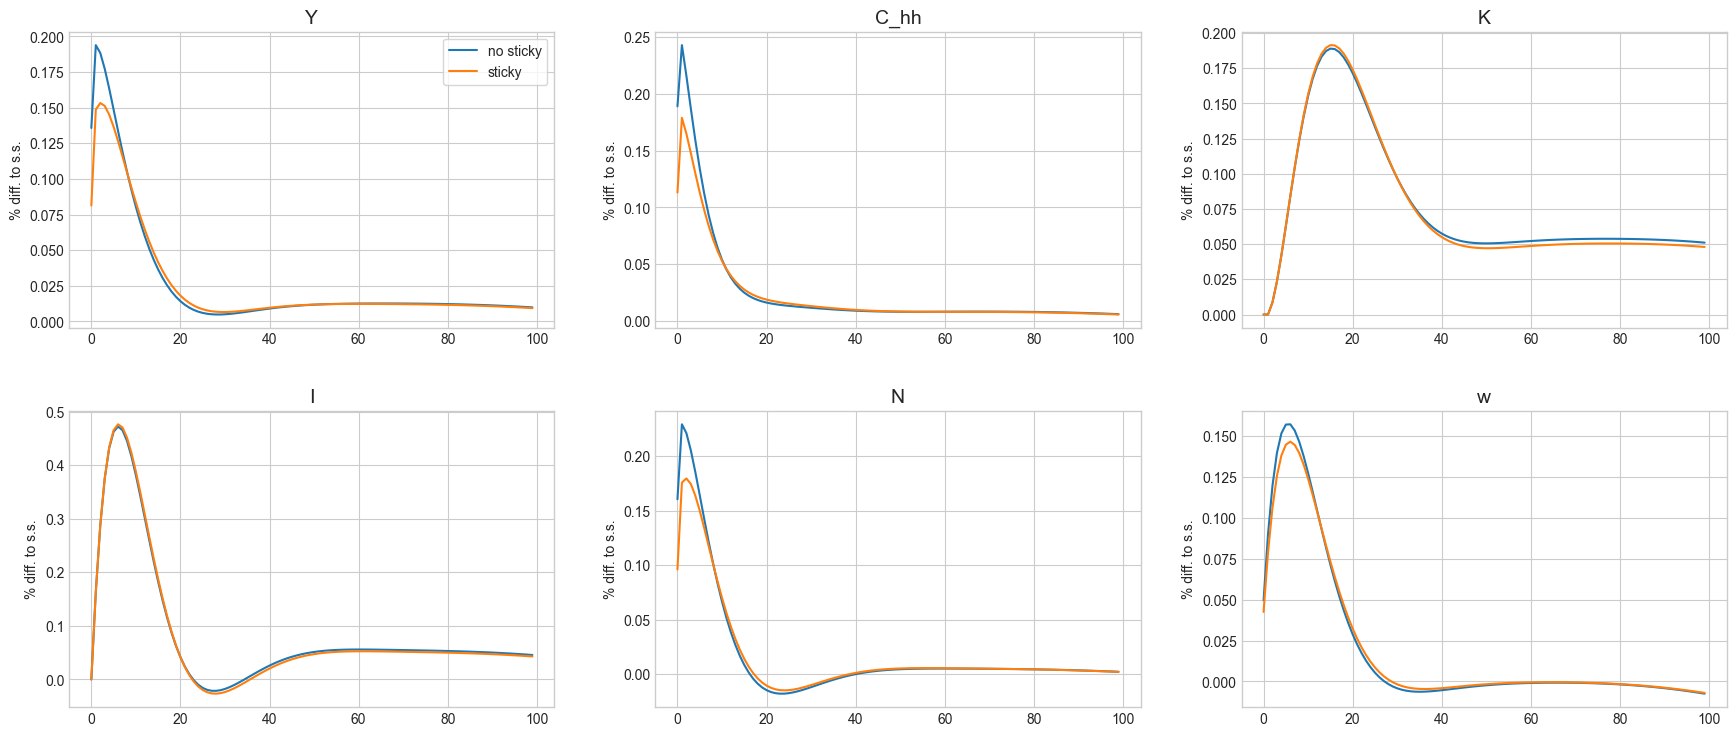


### tagets ###


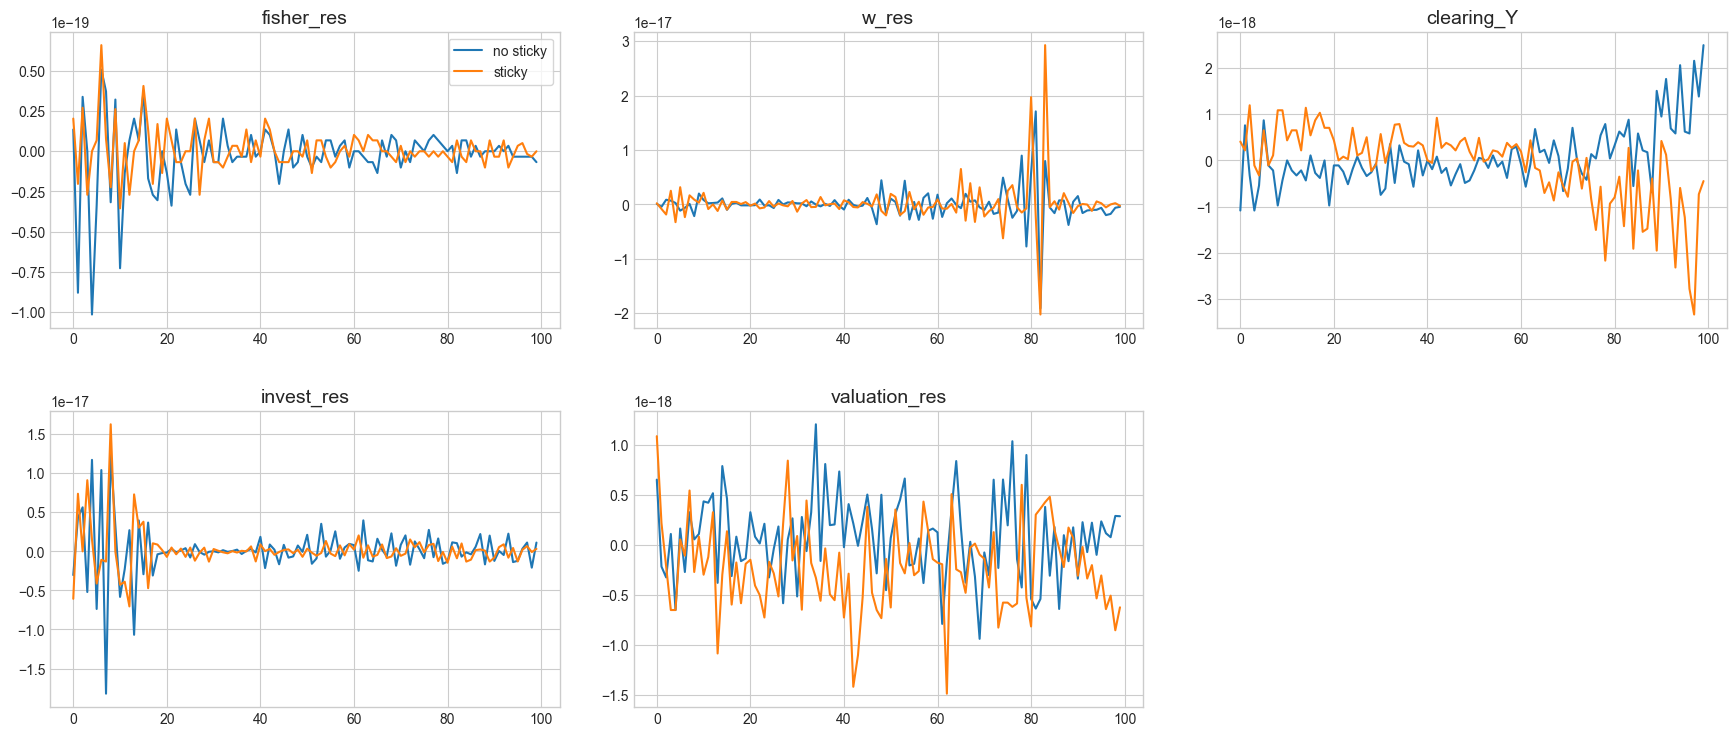

In [12]:
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100,
                   do_linear=True, do_non_linear=False)

### plot more variables

### shocks ###


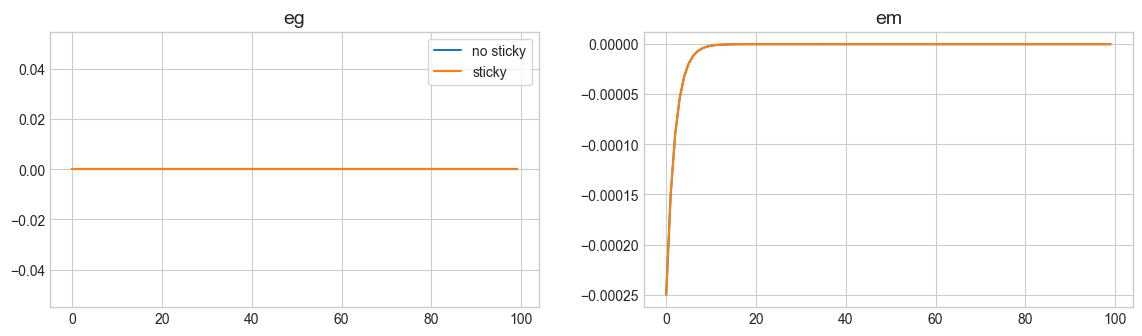


### varnames ###


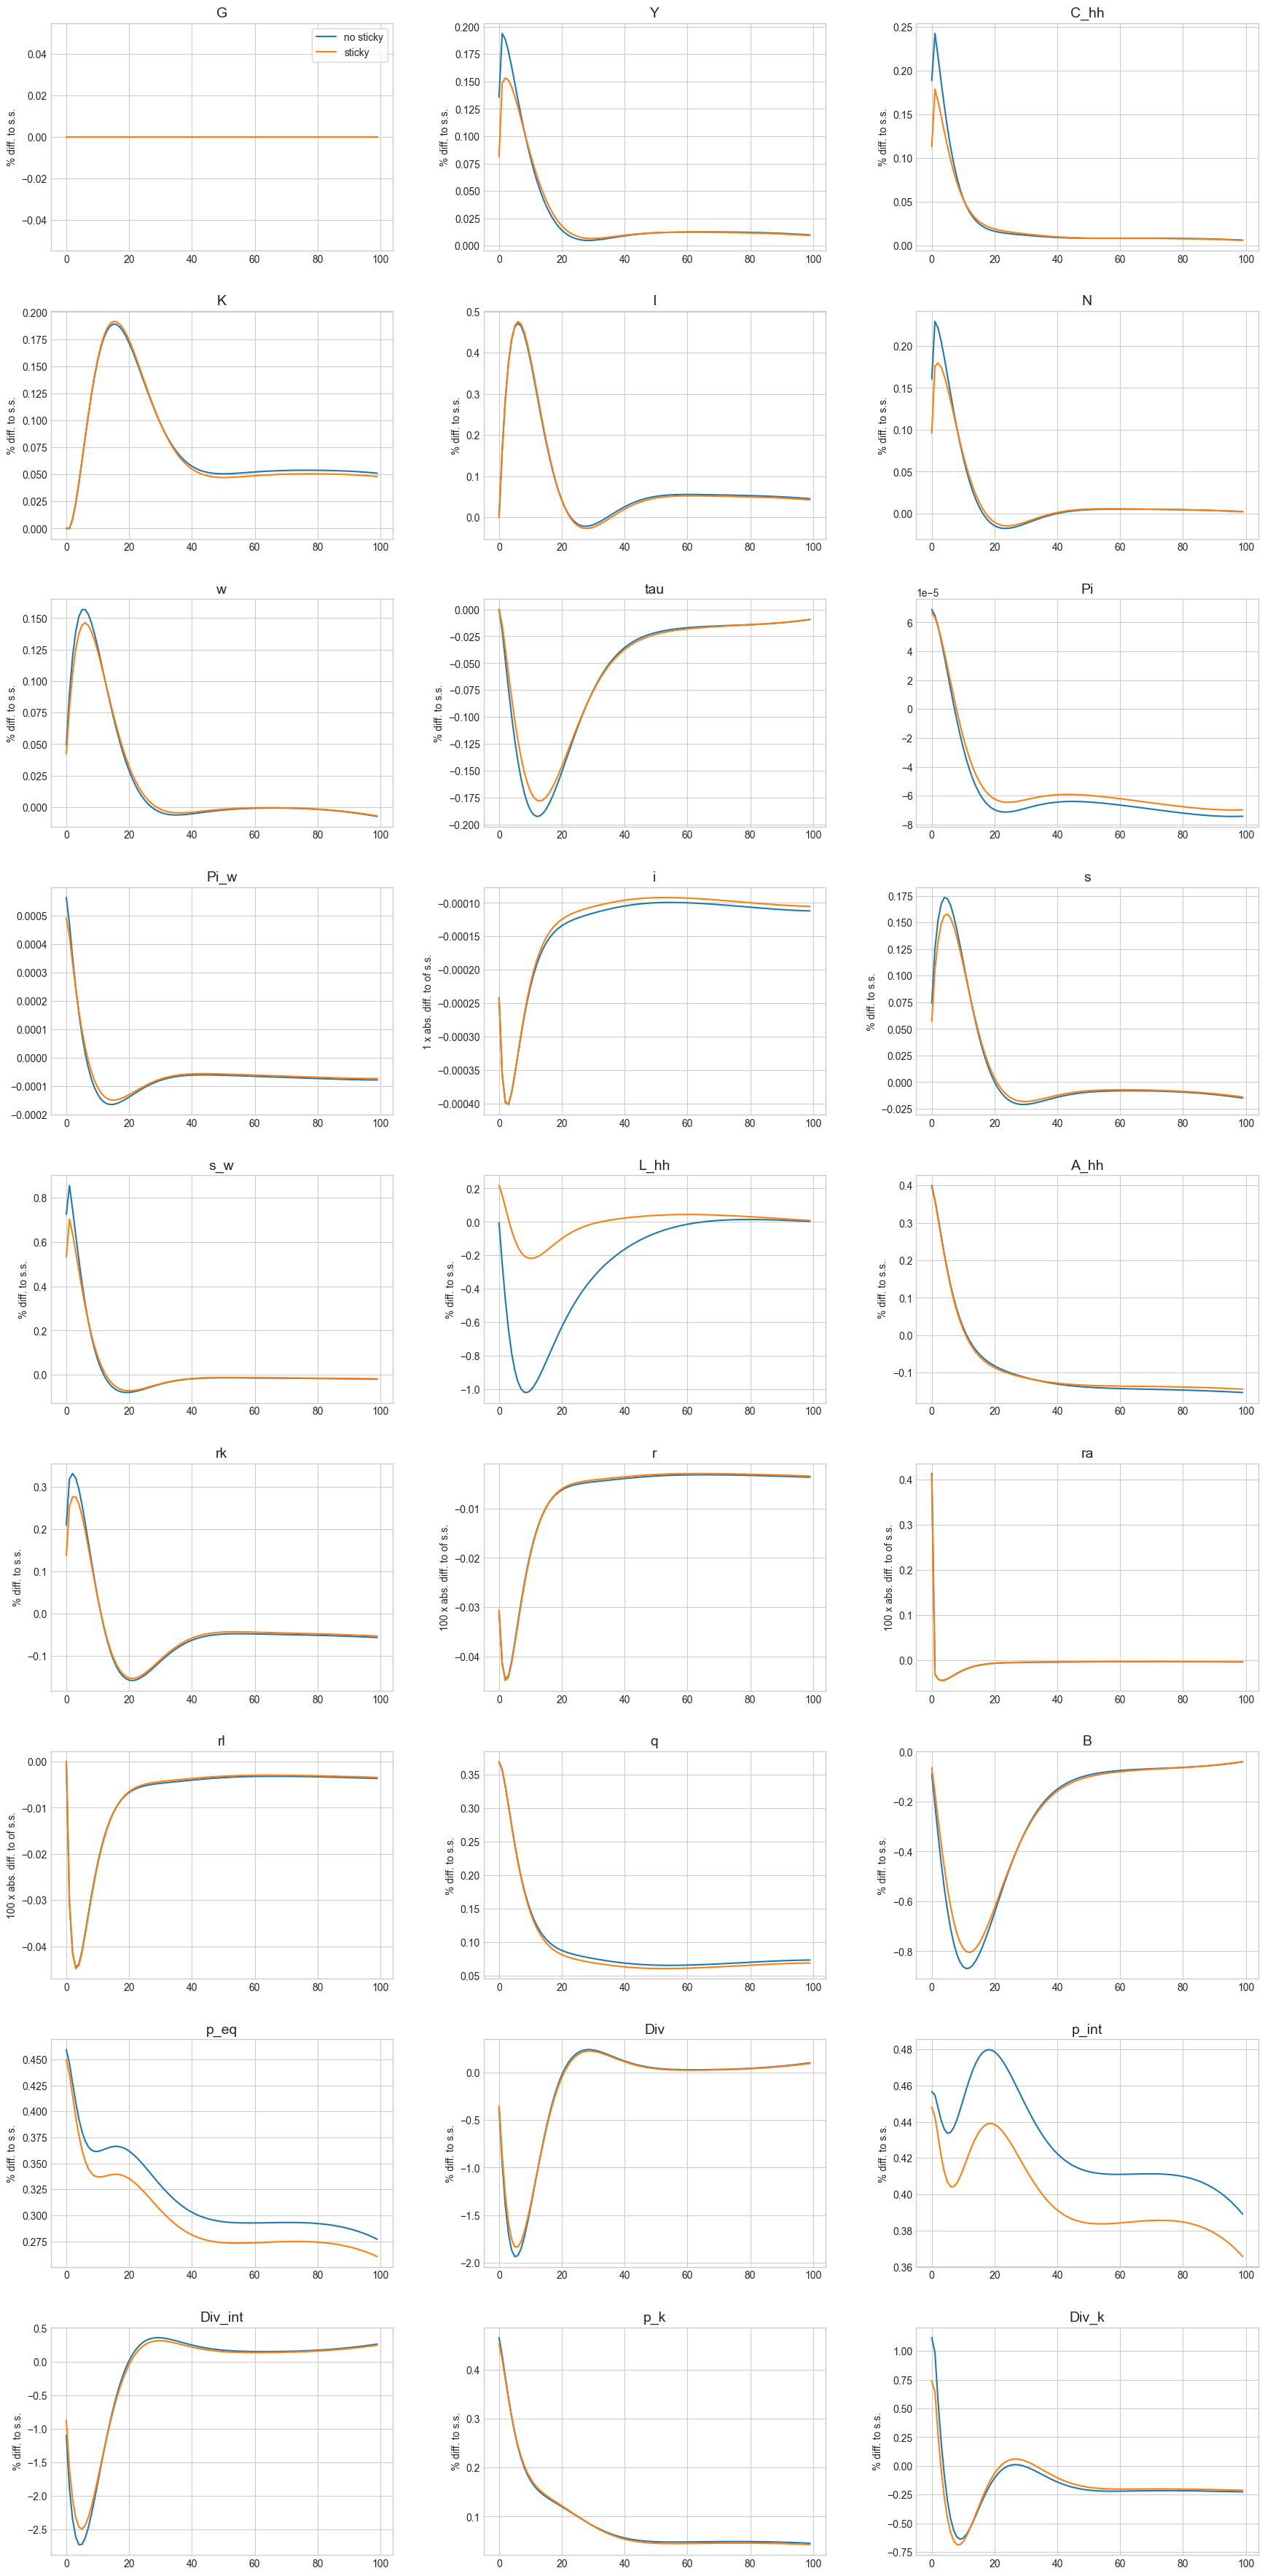


### tagets ###


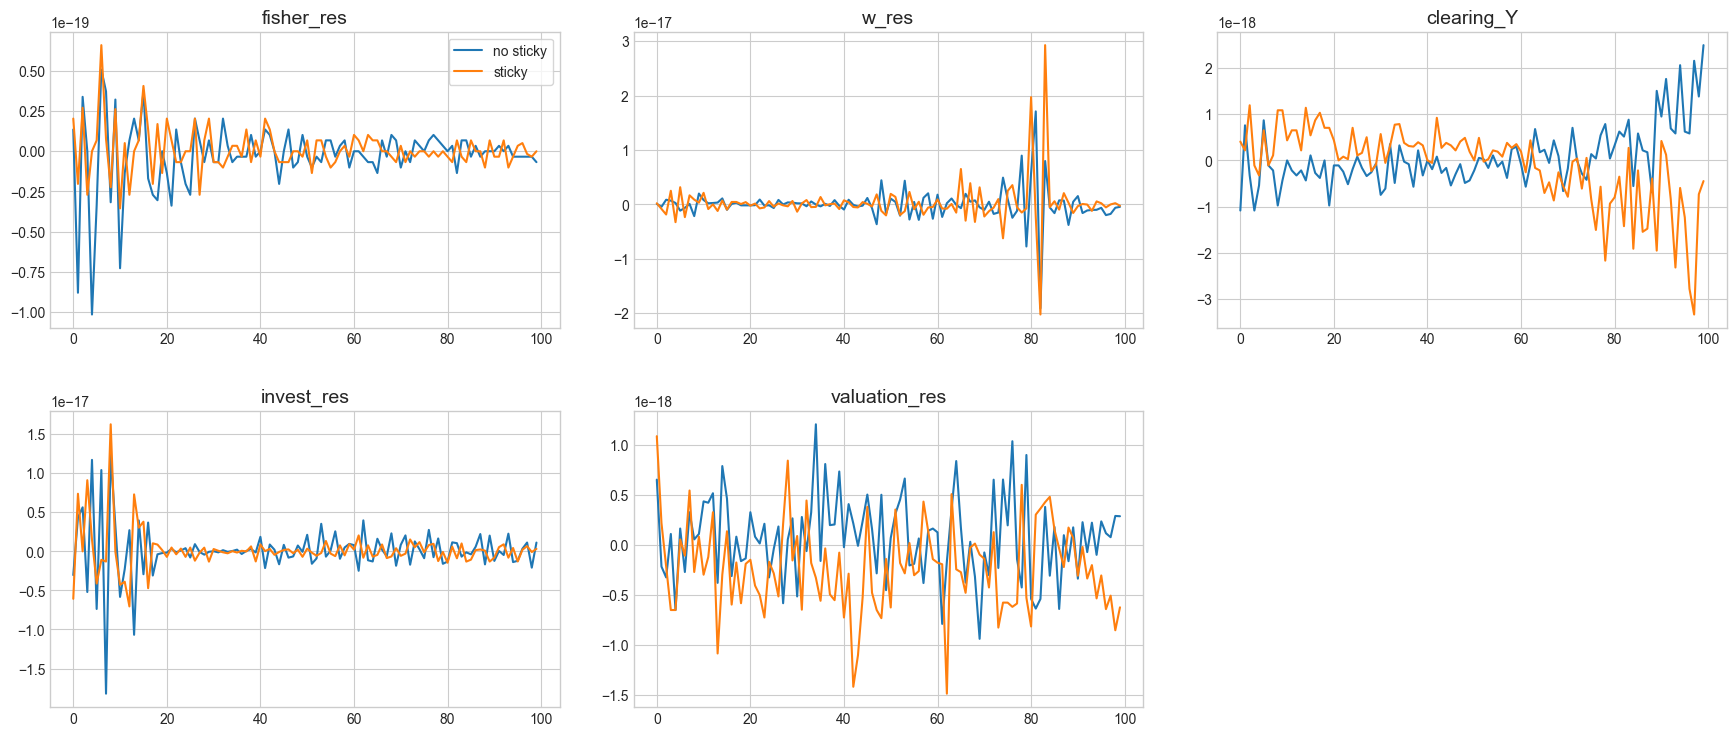

In [13]:
model_sticky.par.jump_em = shock_settings['jump_em']
model_sticky.par.rho_em = shock_settings['rho_em']
model_sticky.par.jump_eg = shock_settings['jump_eg']
model_sticky.find_IRFs()
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100,
                   do_linear=True, do_non_linear=False)